# Introduction  

The purpose of this project is to analyze impact of NBA schedule to a team and help team management be prepared for tougher part of a season.

# Setup and Data    

In [7]:
from datetime import  timedelta
import matplotlib.pyplot as plt
import pandas as pd

schedule = pd.read_csv("Datasets/schedule.csv")
draft_schedule = pd.read_csv("Datasets/schedule_24_partial.csv")
locations = pd.read_csv("Datasets/locations.csv")
game_data = pd.read_csv("Datasets/team_game_data.csv")

## Schedule Analysis
Measure the density of the schedule without considering opponent's strength.

To measure the density, we need to answer:
How many times are a team scheduled to play 4-in-6 (4 games in 6 nights) / B2B(back to back games) in a season?

In [8]:
draft_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   season    160 non-null    int64 
 1   gamedate  160 non-null    object
 2   team      160 non-null    object
 3   opponent  160 non-null    object
 4   home      160 non-null    int64 
 5   win       160 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 7.6+ KB


In [9]:
draft_schedule.head()

,season,gamedate,team,opponent,home,win
0,2024,2025-04-13,DEN,HOU,0,1
1,2024,2025-04-13,OKC,NOP,0,1
2,2024,2025-04-11,OKC,UTA,0,1
3,2024,2025-04-11,DEN,MEM,1,1
4,2024,2025-04-09,OKC,PHX,0,1


Using two pointer to locate the last played game N games before last played game in the season.
Then check whether the date diff, in the case for 4-in-6, is less than 5, if yes we add 1 to the counter.
After checking, we move both pointer forward and repeat the same process till meet the first game of the season.

In [52]:
def density_check(data,teams:list, games_diff:int, day_diff:int):
    #convert data type for the function
    data['gamedate'] = data['gamedate'].astype('datetime64[us]').dt.date
    data['team'] = data['team'].astype('str')

    # I choose to output the entire data in case we need it in other case
    match_record = []
    #prepare team data for pointer
    for team in teams:
        tm = data[data['team'] == team].sort_values('gamedate', ascending=False)
        gamesplayed = len(tm)

        #point by index
        first = 0
        second = games_diff
        
        for n in range(gamesplayed-(games_diff+1)):
            date_diff = (tm.iloc[first]['gamedate'] - tm.iloc[second]['gamedate']).days
            if date_diff < day_diff:
                match_record.append(tm.iloc[first])
            first += 1
            second += 1
    return match_record


In [36]:
density_check(draft_schedule, ['OKC'], 3,6)

[season          2024.0
 gamedate    2025-04-13
 team               OKC
 opponent           NOP
 home               0.0
 win                1.0
 Name: 1, dtype: object,
 season          2024.0
 gamedate    2025-04-11
 team               OKC
 opponent           UTA
 home               0.0
 win                1.0
 Name: 2, dtype: object,
 season          2024.0
 gamedate    2025-04-09
 team               OKC
 opponent           PHX
 home               0.0
 win                1.0
 Name: 4, dtype: object,
 season          2024.0
 gamedate    2025-03-12
 team               OKC
 opponent           BOS
 home               0.0
 win                1.0
 Name: 32, dtype: object,
 season          2024.0
 gamedate    2025-03-10
 team               OKC
 opponent           DEN
 home               1.0
 win                0.0
 Name: 34, dtype: object,
 season          2024.0
 gamedate    2025-03-07
 team               OKC
 opponent           POR
 home               1.0
 win                1.0
 Name: 38

In [35]:
len(density_check(draft_schedule, ['OKC'], 3,6))

26


Compare individual team's count to the league's average, we can have an idea of how tough a team's schedule is relative to others'.


In [13]:
schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23958 entries, 0 to 23957
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   season    23958 non-null  int64 
 1   gamedate  23958 non-null  object
 2   team      23958 non-null  object
 3   opponent  23958 non-null  object
 4   home      23958 non-null  int64 
 5   win       23958 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


In [14]:
# season 2019 and 2020 are shortened
seasons = schedule['season'].unique().tolist()
for season in seasons:
    print(season,':',len(schedule[schedule['season'] == season]))

2014 : 2460
2015 : 2460
2016 : 2460
2017 : 2460
2018 : 2460
2019 : 2118
2020 : 2160
2021 : 2460
2022 : 2460
2023 : 2460


In [15]:
teams = schedule['team'].unique().tolist()
y19 = schedule[schedule['season'] == 2019]
y20 = schedule[schedule['season'] == 2020]

In [16]:
for team in teams:
    print(team,':',len(y19[y19['team'] == team]), len(y20[y20['team'] == team]))

SAC : 72 72
NYK : 66 72
DEN : 73 72
MIA : 73 72
UTA : 72 72
LAL : 71 72
GSW : 65 72
NOP : 72 72
BOS : 72 72
ORL : 73 72
ATL : 67 72
SAS : 71 72
POR : 74 72
HOU : 72 72
MIL : 73 72
TOR : 72 72
OKC : 72 72
BKN : 72 72
CHA : 65 72
MEM : 73 72
CLE : 65 72
CHI : 65 72
DAL : 75 72
DET : 66 72
WAS : 72 72
IND : 73 72
PHI : 73 72
MIN : 64 72
PHX : 73 72
LAC : 72 72


For shorter season,
I choose to adjust the 4-in-6 count by calculate the average 4-in-6 per game for each team in these two season and times it by 82.
For example: if NYK only play 66games and have 20 4-in-6 games in season 2019, the calculation will be : 20/66*82

In [17]:
seasonal_4in6_avg = {}
for season in seasons:
    total_4in6 = 0
    for team in teams:
        st_data = pd.DataFrame(schedule[(schedule['season'] == season)])
        fs_count = len(density_check(st_data, [team], 3, 6))
        games_played = len(st_data[st_data['team'] == team])
        true_fs = fs_count / games_played * 82
        total_4in6 += true_fs

    seasonal_4in6_avg[season] = round(total_4in6 / 30, 2)
seasonal_4in6_avg

{2014: 29.37,
 2015: 27.6,
 2016: 27.73,
 2017: 20.17,
 2018: 19.3,
 2019: 20.23,
 2020: 33.9,
 2021: 23.53,
 2022: 23.4,
 2023: 23.17}

In [60]:
y22 = schedule[schedule['season'] == 2022].copy()
print(len(density_check(y22, ['OKC'], 3,6)))

26


Compare to the league avg 23.4 games in season 2022, OKC's schedule had 26 games which is 2.6 games above average.
But is the difference reasonable? let's use the min and max team to check.

In [169]:
#create dictionary to store team data
team_4in6_avg = {}
for team in teams:
    team_4in6_avg[team] = 0

for season in seasons:
    for team in teams:
        season_data = pd.DataFrame(schedule[(schedule['season'] == season)])
        fs_count = len(density_check(season_data, [team], 3, 6))
        games_played = len(season_data[season_data['team'] == team])
        true_fs = fs_count / games_played * 82

        team_4in6_avg[team] += true_fs / len(seasons)


minteam = round(min(team_4in6_avg.values()),1)
maxteam = round(max(team_4in6_avg.values()),1)
print('minteam',minteam)
print('maxteam',maxteam)
team_4in6_avg

minteam 21.9
maxteam 27.8


{'SAC': 24.783333333333335,
 'NYK': 21.861868686868686,
 'DEN': 22.770700152207002,
 'MIA': 23.35525114155251,
 'UTA': 25.33888888888889,
 'LAL': 23.579616588419405,
 'GSW': 25.337905982905987,
 'NOP': 22.4,
 'BOS': 25.094444444444445,
 'ORL': 23.989117199391174,
 'ATL': 25.897263681592037,
 'SAS': 25.263380281690143,
 'POR': 26.514339339339344,
 'HOU': 24.35277777777778,
 'MIL': 24.13546423135464,
 'TOR': 24.411111111111115,
 'OKC': 25.622222222222227,
 'BKN': 23.113888888888887,
 'CHA': 27.78303418803419,
 'MEM': 25.575913242009133,
 'CLE': 25.60918803418803,
 'CHI': 27.52145299145299,
 'DAL': 23.58666666666667,
 'DET': 26.201515151515153,
 'WAS': 26.419444444444444,
 'IND': 25.95403348554034,
 'PHI': 24.978348554033484,
 'MIN': 25.421180555555555,
 'PHX': 22.1722602739726,
 'LAC': 26.152777777777775}

- Most 4-in-6 stretches on average: CHA (27.8)
- Fewest 4-in-6 stretches on average: NYK (21.9)

In [170]:
import statistics as stat
print('mean:',stat.mean(team_4in6_avg.values()).__round__(1))
print('median:',stat.median(team_4in6_avg.values()).__round__(1))
print('std:', stat.stdev(team_4in6_avg.values()).__round__(1))

mean: 24.8
median: 25.2
std: 1.5


From a simple descriptive view, since both min and max are within 2 standard deviations of the league mean, I **do not** think the difference are too significant.
To confirm this, I compare the difference to the result of 10000 simulations, under a hypothesis where each team’s 4-in-6 count follows a Poisson distribution with the same rate.

In [171]:
import numpy as np

s_mean = 24.8
s_diff = 27.8 - 21.9 #max - min
n_reps = 10000
n_teams = 30
n_seasons = 10


rng = np.random.default_rng(42)  # reproducible
draws = rng.poisson(lam= s_mean, size=(n_reps, n_teams, n_seasons))
team_means = draws.mean(axis=2)
spreads = team_means.max(axis=1) - team_means.min(axis=1)


median_spread = np.median(spreads)
lo, hi = np.percentile(spreads, [2.5, 97.5])

print('median_spread:',median_spread)
print('lo/hi:',lo,',',hi)

median_spread: 6.399999999999999
lo/hi: 4.5 , 8.7


As we can see, the median of max-min in simulation 6.39 is larger than our observed difference 5.9.
The observed difference also lies between the 95% reference range (4.5 , 8.7).
This indicates the difference we observed is likely just a result of chance.

## Trends and Visualizations

Instead of counting how many time a team have b2b/ 4in6 streak, I want to identify every game that is in the streak.
In another word, rather than only marking the 4th game in the 4_in_6, all 4 games will be marked

In [175]:
#getting the b2b and 4-in-6 games data
b2b_index = pd.DataFrame(density_check(schedule, teams, 1, 2))
fin6_index = pd.DataFrame(density_check(schedule, teams, 3, 6))
ns = pd.DataFrame(schedule)

In [176]:
ns['b2b'] = ns.index.isin(b2b_index.index)
ns['4in6'] = ns.index.isin(fin6_index.index)

In [177]:
ns['4in6_range'] = 0
ns['b2b_range'] = 0
# marking all the games in b2b / 4-in-6 stretch, ex: 1st game in b2b = 1, 2nd= 2 in b2b_range.
# 4 is the max number in 4in6, any continue stretch will just be 1,2,3,4,4,4....

# since we can find the 4th game, I start checking from the latest game and mark the 3 games before that.
for team in teams:
    team_data = ns[ns['team'] == team].copy()
    team_data.sort_values('gamedate',ascending=False,inplace=True)
    for idx in range(len(team_data)):

        if ns['4in6'][team_data.index[idx]] == True:
            nth = 4
            for game in range(4):
                ns.loc[(team_data.index[idx+game]),'4in6_range'] = nth
                nth -= 1

        if ns['b2b'][team_data.index[idx]] == True:
            ns.loc[(team_data.index[idx]),'b2b_range'] = 2
            ns.loc[(team_data.index[idx+1]),'b2b_range'] = 1

In [178]:
ns[ns['team']=='OKC'].sort_values('gamedate',ascending=False)

,season,gamedate,team,opponent,home,win,b2b,4in6,4in6_range,b2b_range
21526,2023,2024-04-14,OKC,DAL,1,1,False,True,4,0
21557,2023,2024-04-12,OKC,MIL,1,1,False,True,4,0
21576,2023,2024-04-10,OKC,SAS,1,1,True,True,4,2
21610,2023,2024-04-09,OKC,SAC,1,1,False,False,3,1
21613,2023,2024-04-07,OKC,CHA,0,1,False,True,4,0
...,...,...,...,...,...,...,...,...,...,...
2357,2014,2014-11-04,OKC,TOR,0,0,True,True,4,2
2364,2014,2014-11-03,OKC,BKN,0,0,False,False,3,1
2405,2014,2014-11-01,OKC,DEN,1,1,False,False,2,0
2420,2014,2014-10-30,OKC,LAC,0,0,False,False,1,0


In [179]:
#aggregate by season
season_group = ns.groupby('season').agg({'gamedate':'count','b2b':['sum','mean'], '4in6':['sum','mean']})
season_group.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in season_group.columns]
season_group['b2b_sum'] = round(season_group['b2b_sum']/30,1)
season_group['b2b_mean'] = round(season_group['b2b_mean']*100,1)
season_group['4in6_sum'] = round(season_group['4in6_sum']/30,1)
season_group['4in6_mean'] = round(season_group['4in6_mean']*100,1)
season_group['gamedate_count'] = round(season_group['gamedate_count']/30,1)
season_group.rename(columns={'gamedate_count': 'average_game','b2b_sum':'b2b_per_team','b2b_mean':'b2b_seasonal%','4in6_sum':'4in6_per_team','4in6_mean': '4in6_seasonal%'}, inplace=True)

In [180]:
season_group['b2b_per_team'] = round(season_group['b2b_per_team']/season_group['average_game'] * 82,1)
season_group['4in6_per_team'] = round(season_group['4in6_per_team']/season_group['average_game']*82,1)
season_group

,average_game,b2b_per_team,b2b_seasonal%,4in6_per_team,4in6_seasonal%
season,,,,,
2014,82.0,19.0,23.2,29.4,35.8
2015,82.0,17.8,21.7,28.0,34.1
2016,82.0,16.4,20.0,27.9,34.0
2017,82.0,14.4,17.6,20.4,24.9
2018,82.0,13.3,16.2,19.5,23.8
2019,70.6,12.2,14.9,20.6,25.1
2020,72.0,17.3,21.2,33.9,41.4
2021,82.0,14.1,17.2,23.8,29.0
2022,82.0,13.4,16.3,23.8,29.1



Besides season 2019 and season 2020 which are short season, the overall number of back-to-back / 4-in-6 game have gone down by about 7%.
Meaning the league making better schedule overall, games are more evenly spread withing season.

([<matplotlib.axis.XTick at 0x1dc426180d0>,
 [Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023')])

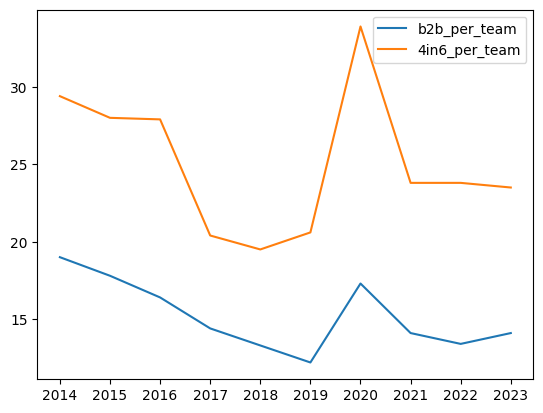

In [181]:
plt.plot(season_group[['b2b_per_team', '4in6_per_team']])
plt.legend(['b2b_per_team', '4in6_per_team'])
plt.xticks(seasons)

In [182]:
# counting the average gap(days) between 4-in-6 stretch, I use total gap days / count of continue stretch to calculate avg gap
avg_seasonal_gap = {}
min_seasonal_gap = {}
for season in seasons:
    team_gapd = 0
    gap_list = []
    for team in teams:
        team_data = ns[(ns['team'] == team) & (ns['season'] == season)].sort_values('gamedate',ascending=True).reset_index(drop=True)
        gapdays = 0
        stretch_count = 0
        pp = 0 if team_data.loc[0,'4in6_range'] == 0 else 1
        first_date = team_data.loc[0,'gamedate']
        for idx in range(1,len(team_data)):
            if (team_data['4in6_range'][idx] >0) & (pp == 0):
                stretch_count += 1
                if first_date < team_data.loc[idx,'gamedate']:
                    gap_list.append((team_data.loc[idx,'gamedate'] - first_date).days -1)
                    gapdays += (team_data.loc[idx,'gamedate'] - first_date).days -1
                pp = 1

            if (team_data['4in6_range'][idx] == 0) & (pp == 1):
                first_date = team_data.loc[idx-1,'gamedate']
                pp = 0

        team_gapd += round(gapdays/stretch_count,1)
    gap_list.sort()
    min_seasonal_gap[season] = gap_list[:10]
    avg_seasonal_gap[season] = round(team_gapd/30,1)

([<matplotlib.axis.XTick at 0x1dc4328bd60>,
 [Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023')])

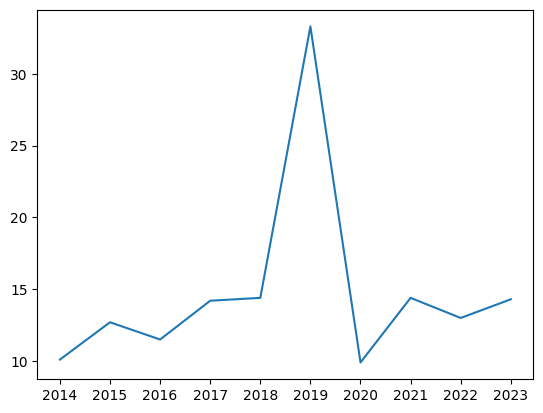

In [183]:
plt.plot(avg_seasonal_gap.keys(), avg_seasonal_gap.values())
plt.xticks(seasons)

In [184]:
#check for 10 smallest gap each season
min_seasonal_gap

{2014: [0, 0, 1, 1, 1, 1, 1, 1, 1, 2],
 2015: [1, 1, 1, 2, 3, 3, 3, 3, 3, 3],
 2016: [1, 1, 1, 1, 2, 2, 2, 2, 3, 3],
 2017: [1, 1, 1, 1, 2, 2, 2, 3, 3, 3],
 2018: [1, 1, 2, 2, 3, 4, 4, 4, 4, 4],
 2019: [2, 2, 2, 3, 3, 3, 3, 3, 3, 4],
 2020: [1, 1, 2, 2, 2, 2, 2, 2, 2, 2],
 2021: [1, 1, 2, 2, 2, 3, 3, 3, 3, 4],
 2022: [1, 2, 3, 3, 3, 3, 3, 4, 4, 4],
 2023: [1, 1, 1, 2, 2, 2, 2, 3, 3, 3]}

Days in between 4-in-6 streak also become longer, and the minimum days between streak have also grown.
Teams are having more break time in between tough schedules.

In [185]:
# std list of ecah team's 4in6/b2b count store in dictionary, and run std for each season
team_4in6_count,team_b2b_count = {}, {}

for season in seasons:
    list_4in6,list_b2b = [], []

    for team in teams:
        list_4in6.append(ns[(ns['team'] == team) & (ns['season'] == season)]['4in6'].sum())
        list_b2b.append(ns[(ns['team'] == team) & (ns['season'] == season)]['b2b'].sum())

    team_4in6_count[season] = round(np.std(list_4in6),1)
    team_b2b_count[season] = round(np.std(list_b2b),1)
team_4in6_count, team_b2b_count

({2014: 3.7,
  2015: 2.4,
  2016: 3.3,
  2017: 2.7,
  2018: 3.3,
  2019: 2.9,
  2020: 5.2,
  2021: 3.6,
  2022: 3.0,
  2023: 3.4},
 {2014: 1.6,
  2015: 1.7,
  2016: 1.3,
  2017: 0.8,
  2018: 0.9,
  2019: 1.3,
  2020: 1.4,
  2021: 1.4,
  2022: 1.2,
  2023: 0.9})

Having lower standard division mean the difference in schedule density is getting smaller between teams.
Team's record is less impact by the schedule difference in a season.

### Dashboard Design
To visualize the entire season, I designed a Gantt chart using plotly, displaying the schedule for the selected season/ team.
There are three argument:
{ **df** }  is the schedule data in pd.DataFrame,
{  **season**  } is the selected season(int), and
{**default_team**  } take team's abbreviation in string ( like 'OKC").
I use color and categories to show the density of the schedule, with more information pop up when point to the block.
There's also a timeline that is adjustable, and a dropdown list allow you to select different teams in the same season.

In [67]:
import plotly.express as px
import plotly.graph_objects as go

#prepare data for plot
def build_team_schedule(df_team: pd.DataFrame) -> pd.DataFrame:

    t = df_team.copy().sort_values('gamedate',ascending=False).reset_index(drop=True)
    t['gamedate'] = pd.to_datetime(t.gamedate)
    t['prev_date'] = t['gamedate'].shift(-1)
    t['rest_days'] = (t['gamedate'] - t['prev_date']).dt.days
    t['rest_days']= t['rest_days'].fillna(0)

    t['b2b'] = t['rest_days'] == 1



    teams = t['team'].unique()
    fin6_index = pd.DataFrame(density_check(t, teams, 3, 6))
    t['4in6'] = t.index.isin(fin6_index.index)

    # mark all games in the stretch like 4in6/ b2b, and count how many game are played in the past 6 days
    t['b2b_range'] = 0
    t['4in6_range'] = 0
    t['games_last6'] = 1

    for team in teams:
        team_data = t[t['team'] == team].copy()
        team_data.sort_values('gamedate',ascending=False,inplace=True)

        for idx in range(len(team_data)):
            t_index = team_data.index
            if t.loc[t_index[idx],'4in6'] == True:
                nth = 4
                for game in range(4):
                    t.loc[t_index[idx+game],'4in6_range'] = nth
                    nth -= 1
            if t.loc[idx,'b2b'] == True:
                t.loc[t_index[idx],'b2b_range'] = 2
                t.loc[t_index[idx+1],'b2b_range'] = 1


            start = t.loc[t_index[idx],'gamedate'] - timedelta(days=5,hours=23,minutes=59)

            t.loc[t_index[idx],'games_last6'] = team_data[
                (team_data['gamedate'] >= start) &
                (team_data['gamedate'] <= team_data.loc[t_index[idx],'gamedate'])
            ].shape[0]



    # category lane
    def lane(row):
        if row['b2b_range']>0:
            return 'Back-to-Back'
        elif row['4in6_range']>0:
            return '4-in-6'
        else:
            return 'Normal'
    t['category'] = t.apply(lane, axis=1)

    # Label text & block span
    t['home_away'] = t['home'].map({1: 'Home', 0: 'Away'})
    t['text'] = t.apply(lambda r: f"{r['home_away']} vs {r['opponent']}", axis=1)
    t['start'] = t['gamedate']
    t['end']   = t['gamedate'] + timedelta(days=1)
    return t


In [68]:
# plot function
def schedule_gantt_plot(
    df: pd.DataFrame,
    season: int,
    default_team: str | None = None
):

    # ensure datetime
    df = df.copy()
    df['gamedate'] = pd.to_datetime(df['gamedate'])

    # filter season & sort
    dfs = df[df['season'] == season].copy()
    if dfs.empty:
        raise ValueError(f"No rows found for season={season}.")

    teams = sorted(dfs['team'].unique())
    if default_team is None:
        default_team = teams[0]
    elif default_team not in teams:
        raise ValueError(f"default_team:'{default_team}' not found in season {season}. Available: {teams}")

    # base team figure
    ts0 = build_team_schedule(dfs[dfs['team'] == default_team].sort_values('gamedate'))
    base = px.timeline(
        ts0,
        x_start="start", x_end="end",
        y="category",
        color="games_last6",
        text="text",
        title=f"{default_team} Schedule Density ({season} Season)",
        hover_data={
            "gamedate": True, "home_away": True, "opponent": True,
            "rest_days": True, "b2b": True, "4in6": True, "games_last6": True,
            "start": False, "end": False, "category": False, "text": False
        },
        color_continuous_scale="Turbo",
    )
    base.update_traces(textposition='inside', insidetextanchor='start')
    base.update_yaxes(categoryorder="array", categoryarray=["Back-to-Back", "4-in-6", "Normal"])
    base.update_layout(
        xaxis_title="Date",
        yaxis_title="Schedule Category",
        height=560,
        margin=dict(l=160, r=40, t=160),
        coloraxis_colorbar=dict(title="Games in last 6 days")
    )
    base.update_xaxes(
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=[
                dict(count=14, label="2W", step="day",   stepmode="backward"),
                dict(count=1,  label="1M", step="month", stepmode="backward"),
                dict(count=3,  label="3M", step="month", stepmode="backward"),
                dict(step="all")
            ]
        )
    )

    fig = go.Figure(base)

    # team dropdown frames
    if len(teams)>0:
        frames = []
        for tm in teams:
            ts = build_team_schedule(dfs[dfs['team'] == tm].sort_values('gamedate'))
            f = px.timeline(
                ts, x_start="start", x_end="end", y="category",
                color="games_last6", text="text", color_continuous_scale="Turbo",
                hover_data={
                    "gamedate": True, "home_away": True, "opponent": True,
                    "rest_days": True, "b2b": True, "4in6": True, "b2b_range":True, "games_last6": True,
                    "start": False, "end": False, "category": False, "text": False
                }
            )
            for tr in f.data:
                tr.textposition = 'inside'
                tr.insidetextanchor = 'start'
            frames.append(go.Frame(
                data=f.data,
                name=tm,
                layout=go.Layout(title_text=f"{tm} Schedule Density ({season} Season)")
            ))
        fig.frames = frames

        buttons = [
            dict(label=tm, method="animate",
                args=[[tm], {"mode": "immediate", "frame": {"duration": 0, "redraw": True}, "transition": {"duration": 0}}]
            )for tm in teams
        ]
        fig.update_layout(
            updatemenus=[
                dict(
                    type="dropdown", showactive=True,
                    x=0.4, xanchor="center", y=1.15, yanchor="top",
                    buttons=buttons
                )
            ]
        )

    return fig

In [69]:
fig = schedule_gantt_plot(
    df=draft_schedule,
    season=2024
)
fig

Using my tool, we can easily identify the best and worst part of a team's schedule, and make rotation plan accordingly.
Let's use OKC's 2024-2025 season as example:

In [189]:
fig = schedule_gantt_plot(
    df=draft_schedule,
    season=2024, default_team = 'OKC'
)
fig

The 2024-25 season open with a tight schedule, but having 6 home game streak around mid Nov(8 ~17) and following with lighter schedule (after Nov-20 till Dec 18) definitely make it more manageable.
  The toughest part of the season come around the end of Feb till Mar 16, with 8 back-to-back, mostly guest games pack in a month. Team should be ready and comes up with careful rotation and rest days plan to avoid risk of injure.
  Good thing is that right after the most taxing period, comes the best schedule in the season. From Mar-19 till Apr-02 we have 8 games, no 4_in_6 or back-to-back, and 6 home games. This is especially good to offsetting some load and getting our focus on play-off preparation.

## Schedule Impact

Estimate how many more/fewer regular season wins each team has had due to schedule-related factors.
I use data from season 2019-20 though 2023-24

To quantify how much travel and schedule density affect win probability, I choose to use a logistic regression model.
The dependent variable is `win`, and the independent variables are schedule factors and team strength.

First I will train the model using train data from the years we don't need. And use test data to evaluate it.
Then I use the model to predict win without any effect from schedule, and compare the result with the actual data.
The difference between predicted and actual win will help us quantify the effect of schedule.

In [190]:
# prepare features for model
team_schdule = schedule.copy()
team_schdule['gamedate'] = pd.to_datetime(team_schdule['gamedate'])
ts = build_team_schedule(team_schdule)

ts['home_team'] = ts.apply(lambda r: r['team'] if r['home'] ==1 else r['opponent'], axis=1)
ts['from_city'] = ts.apply(lambda r: r['opponent'] if r['rest_days'] < 3 else r['team'],axis=1)

#seasonal_winrate
winrate_map = pd.DataFrame(seasons).merge(pd.DataFrame(teams), how = 'cross').copy()
winrate_map.rename(columns={'0_x':'season', '0_y':'team'}, inplace=True)
for season in seasons:
    for team in teams:
        season_team_schedule = schedule[(schedule['team']==team) & (schedule['season']==season)]
        winrate = round(sum(season_team_schedule['win'])*100 / len(season_team_schedule),1)
        winrate_map.loc[(winrate_map['season'] == season) & (winrate_map['team']==team),'winrate'] = winrate

ts = ts.merge(winrate_map, how='left', on=['season','team'])
ts = ts.merge(winrate_map, how='left', left_on=['season','opponent'], right_on=['season','team'])

ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23958 entries, 0 to 23957
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   season       23958 non-null  int64         
 1   gamedate     23958 non-null  object        
 2   team_x       23958 non-null  object        
 3   opponent     23958 non-null  object        
 4   home         23958 non-null  int64         
 5   win          23958 non-null  int64         
 6   prev_date    23957 non-null  datetime64[ns]
 7   rest_days    23958 non-null  float64       
 8   b2b          23958 non-null  bool          
 9   4in6         23958 non-null  bool          
 10  b2b_range    23958 non-null  int64         
 11  4in6_range   23958 non-null  int64         
 12  games_last6  23958 non-null  int64         
 13  category     23958 non-null  object        
 14  home_away    23958 non-null  object        
 15  text         23958 non-null  object        
 16  star

In [191]:
ts.rename(columns={
    'team_x':'team',
    'winrate_x':'team_winrate',
    'winrate_y': 'opponent_winrate',
    '4in6_range': 'f4in6_range'
}, inplace=True)

ts.drop(columns=['prev_date', 'category', 'home_away', 'text','start','end','team_y','4in6','b2b'], inplace=True)
ts.head()

,season,gamedate,team,opponent,home,win,rest_days,b2b_range,f4in6_range,games_last6,home_team,from_city,team_winrate,opponent_winrate
0,2023,2024-04-14,MIA,TOR,1,1,0.0,0,4,4,MIA,TOR,56.1,30.5
1,2023,2024-04-14,LAC,HOU,1,0,0.0,0,4,4,LAC,HOU,62.2,50.0
2,2023,2024-04-14,ORL,MIL,1,1,0.0,0,4,4,ORL,MIL,57.3,59.8
3,2023,2024-04-14,ATL,IND,0,0,0.0,0,4,4,IND,IND,43.9,57.3
4,2023,2024-04-14,NOP,LAL,1,0,0.0,0,4,4,NOP,LAL,59.8,57.3


In [192]:
# use the following command to install haversine if you didn't have it
# pip install haversine

In [193]:
# this function is for converting (lat, lon) into distant
from haversine import  haversine, Unit

locations_distance = locations.copy()
locations_distance['lat_lon'] = list(zip(locations_distance['latitude'],locations_distance['longitude']))

loc_cross = locations_distance.merge(locations_distance , how='cross',)
loc_cross['distant'] = round(loc_cross.apply(lambda r: haversine(r['lat_lon_x'], r['lat_lon_y'], unit=Unit.MILES),axis=1),1)

tz_to_offset = {'Eastern': -5, 'Central': -6, 'Mountain': -7, 'Pacific': -8}
loc_cross['zone_diff'] = loc_cross.apply(lambda r: tz_to_offset[r['timezone_x']] - tz_to_offset[r['timezone_y']], axis=1)

In [194]:
loc_cross[['team_x','team_y','distant', 'zone_diff']]

,team_x,team_y,distant,zone_diff
0,ATL,ATL,0.0,0
1,ATL,BOS,936.1,0
2,ATL,BKN,745.8,0
3,ATL,CHA,226.5,0
4,ATL,CHI,589.0,1
...,...,...,...,...
895,WAS,SAC,2372.8,3
896,WAS,SAS,1383.4,1
897,WAS,TOR,350.0,0
898,WAS,UTA,1843.0,2


In [195]:
#merge location distant, zone_diff with ts base on from city and home team
loc_sche_merge = ts.merge(
    loc_cross[['team_x','team_y','distant', 'zone_diff']],
    how= 'left', left_on=['from_city','home_team'], right_on=['team_x','team_y']
)
loc_sche_merge.drop(['team_x','team_y'], axis=1, inplace=True)

In [196]:
train_df = loc_sche_merge[loc_sche_merge["season"].between(2014, 2018)].copy()
test_df  = loc_sche_merge[loc_sche_merge["season"].between(2019, 2023)].copy()

In [197]:
import statsmodels.formula.api as smf

formula = """
    win ~ rest_days
         + C(b2b_range)
         + C(f4in6_range)
         + games_last6
         + distant
         + zone_diff
         + home
         + team_winrate
         + opponent_winrate
"""

# fit logistic regression
model = smf.logit(formula=formula, data=train_df).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.580026
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                12300
Model:                          Logit   Df Residuals:                    12286
Method:                           MLE   Df Model:                           13
Date:                Sun, 24 Aug 2025   Pseudo R-squ.:                  0.1632
Time:                        01:27:09   Log-Likelihood:                -7134.3
converged:                       True   LL-Null:                       -8525.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3566      0.178     -1.998      0.046      -0.706      -0.007
C(

In [198]:
summary_table = pd.DataFrame({
    "Variable": model.params.index,
    "Coefficient": model.params.values,
    "Odds Ratio": np.exp(model.params.values),
    "p-value": model.pvalues.values
})

print(summary_table)

               Variable  Coefficient  Odds Ratio        p-value
0             Intercept    -0.356621    0.700038   4.570185e-02
1     C(b2b_range)[T.1]    -0.124780    0.882691   1.229660e-01
2     C(b2b_range)[T.2]    -0.063412    0.938556   4.328968e-01
3   C(f4in6_range)[T.1]     0.058753    1.060513   4.201340e-01
4   C(f4in6_range)[T.2]    -0.025983    0.974351   7.128967e-01
5   C(f4in6_range)[T.3]     0.005847    1.005864   9.289501e-01
6   C(f4in6_range)[T.4]    -0.025727    0.974601   7.542621e-01
7             rest_days     0.002514    1.002517   7.070063e-01
8           games_last6    -0.013872    0.986223   7.895817e-01
9               distant    -0.000069    0.999931   1.252358e-01
10            zone_diff     0.022568    1.022825   2.643190e-01
11                 home     0.901178    2.462502   4.578292e-47
12         team_winrate     0.047683    1.048838  5.624235e-234
13     opponent_winrate    -0.047634    0.953482  4.574832e-233


Compare to other feature, 3rd, 4th game in 4_in_6 streak and having home advantage are the most influence factor to winrate.

In [199]:
from sklearn.metrics import roc_curve, roc_auc_score
test_df["pred_test"] = model.predict(test_df)

# evaluate performance
auc_score = roc_auc_score(test_df["win"], test_df["pred_test"])
print("Test ROC AUC:", auc_score)

Test ROC AUC: 0.7329129225059798


Means the model correctly distinguishes wins from losses ~75% of the time.
Decent AUC for sport game which naturally comes with a lot of noise

ROC AUC: 0.7329129225059798


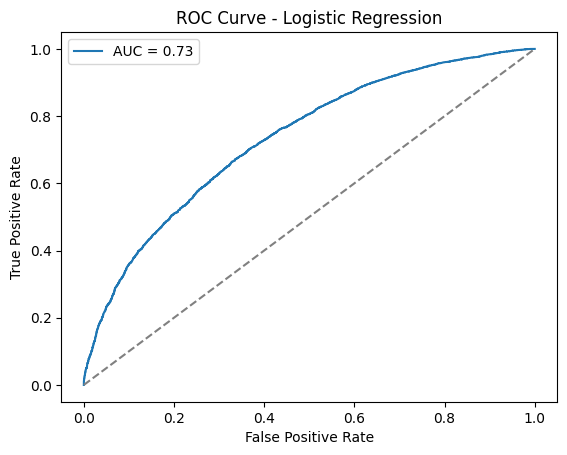

In [200]:
# predicted probabilities for win
y_pred_proba = model.predict(test_df)

# true values
y_true = test_df['win']

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)
print("ROC AUC:", auc_score)

# plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In [201]:
test_df["pred_actual"] = model.predict(test_df)

In [202]:
neutral_df = test_df.copy()

# set schedule-related stressors to "neutral", remove the effect of these factor
neutral_df["rest_days"] = 2
neutral_df["b2b_range"] = 0
neutral_df["4in6_range"] = 0
neutral_df["games_last6"] = 3
neutral_df["distant"] = 0
neutral_df["zone_diff"] = 0

In [203]:
neutral_df["pred_neutral"] = model.predict(neutral_df)

In [204]:
# merge back actual vs neutral
test_df["pred_neutral"] = neutral_df["pred_neutral"]

# Compare the predicted result of Actual and Neutral to see the effect on win.
team_summary = (
    test_df.groupby(["season", "team"])[["win", "pred_neutral"]]
    .sum()
    .reset_index()
)

# Calculate schedule effect
team_summary["schedule_effect"] = (
    team_summary["win"] - team_summary["pred_neutral"]
)

In [205]:
final_effects = (
    team_summary
    .groupby("team")["schedule_effect"]
    .sum()
    .sort_values()
)
print(final_effects)

team
MIA   -7.326422
PHI   -6.816085
MIL   -6.784522
DET   -6.726630
WAS   -6.656276
CLE   -6.459846
CHI   -6.459482
BKN   -6.209830
DEN   -6.043445
DAL   -5.791208
MEM   -5.451533
BOS   -5.387381
NYK   -5.054635
ATL   -4.817105
CHA   -4.363792
LAC   -4.107226
PHX   -4.095423
GSW   -4.094302
IND   -3.556608
TOR   -3.494900
ORL   -3.179329
MIN   -3.082438
HOU   -2.971733
UTA   -2.934222
OKC   -2.803472
LAL   -2.231343
SAC   -1.517422
NOP   -1.297965
POR   -0.988811
SAS   -0.266194
Name: schedule_effect, dtype: float64


Using this method, we can measure impact of a schedule by wins diff, and we can also further exam how much each factor impact the outcomes of a game by adjusting our neutral game setting.
These result can help teams adjust rotation, get player to be prepared, and avoid injury cause by burnout.
It can also help the league to make adjustment when making schedule, ensure every team having more equally distributed schedule.